In [1]:
from pynvml import *

nvmlInit()
vram = nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(0)).free/1024.**2
print('GPU0 Memory: %dMB' % vram)
if vram < 8000:
    raise Exception('GPU Memory too low')
nvmlShutdown()

GPU0 Memory: 11172MB


# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha) 的库来生成验证码。

我们生成验证码的字符由数字和几个运算符组成。

`/usr/local/lib/python2.7/dist-packages/captcha/image.py`

0123456789+-*() 
17


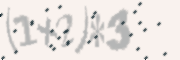

In [2]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
digits = string.digits
operators = '+-*'
characters = digits + operators + '() '
print(characters)

width, height, n_len, n_class = 180, 60, 7, len(characters) + 1
print(n_class)

from IPython.display import display
generator = ImageCaptcha(width=width, height=height, font_sizes=range(35, 56), 
                         fonts=['fonts/%s'%x for x in os.listdir('fonts') if '.tt' in x])
display(generator.generate_image('(1+2)*3'))

# 生成混合运算字符串

In [3]:
def generate():
    seq = ''
    k = random.randint(0, 2)
    
    if k == 1:
        seq += '('
    seq += random.choice(digits)
    seq += random.choice(operators)
    if k == 2:
        seq += '('
    seq += random.choice(digits)
    if k == 1:
        seq += ')'
    seq += random.choice(operators)
    seq += random.choice(digits)
    if k == 2:
        seq += ')'
    
    return seq

generate()

'(9-3)+9'

# 定义 CTC Loss

In [4]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


# 定义网络结构

In [22]:
from keras.layers import *
from keras.models import *
from make_parallel import make_parallel
rnn_size = 128

input_tensor = Input((width, height, 3))
x = input_tensor
for i in range(3):
    x = Conv2D(32*2**i, (3, 3), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32*2**i, (3, 3), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)

x = Dense(128, kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
             name='gru1_b')(x)
gru1_merged = add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
             name='gru2_b')(gru1_merged)
x = concatenate([gru_2, gru_2b])
x = Dropout(0.25)(x)
x = Dense(n_class, kernel_initializer='he_normal', activation='softmax')(x)
base_model = Model(input=input_tensor, output=x)

base_model2 = make_parallel(base_model, 4)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64')
loss_out = Lambda(ctc_lambda_func, name='ctc')([base_model2.output, labels, input_length, label_length])

model = Model(inputs=(input_tensor, labels, input_length, label_length), outputs=loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


# 定义数据生成器

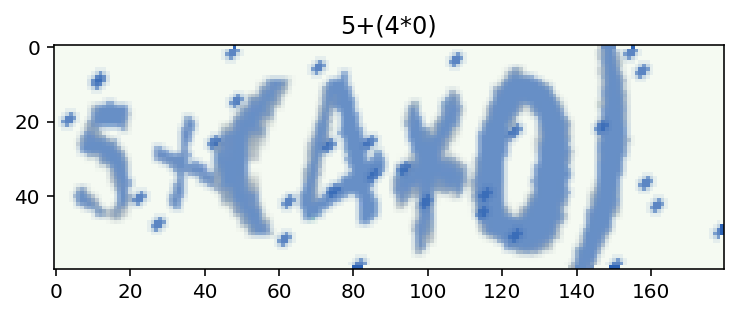

In [6]:
def gen(batch_size=128):
    X = np.zeros((batch_size, width, height, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.int32)
    label_length = np.ones(batch_size)
    while True:
        for i in range(batch_size):
            random_str = generate()
            X[i] = np.array(generator.generate_image(random_str)).transpose(1, 0, 2)
            y[i,:len(random_str)] = [characters.find(x) for x in random_str]
            y[i,len(random_str):] = -1
            label_length[i] = len(random_str)
        yield [X, y, np.ones(batch_size)*int(conv_shape[1]-2), label_length], np.ones(batch_size)

[X_test, y_test, _, label_length_test], _  = next(gen(1))
plt.imshow(X_test[0].transpose(1, 0, 2))
plt.title(''.join([characters[x] for x in y_test[0]]))

# 验证函数和回调函数

In [17]:
from tqdm import tqdm
import pandas as pd
import cv2

df = pd.read_csv('image_contest_level_1/labels.txt', sep=' ', header=None)
n_test = 100000
X_test = np.zeros((n_test, width, height, 3), dtype=np.uint8)
y_test = np.zeros((n_test, n_len), dtype=np.int32)
label_length_test = np.zeros((n_test, 1), dtype=np.int32)

for i in tqdm(range(n_test)):
    img = cv2.imread('image_contest_level_1/%d.png'%i)
    X_test[i] = img[:,:,::-1].transpose(1, 0, 2)
    random_str = df[0][i]
    y_test[i,:len(random_str)] = [characters.find(x) for x in random_str]
    y_test[i,len(random_str):] = -1
    label_length_test[i] = len(random_str)

100%|██████████| 100000/100000 [00:26<00:00, 3791.98it/s]


In [14]:
def evaluate(model):
    y_pred = base_model2.predict(X_test, batch_size=1024)
    shape = y_pred[:,2:,:].shape
    out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:, :n_len]
    if out.shape[1] > 4:
        return (y_test == out).all(axis=-1).mean()
    return 0

In [15]:
from keras.callbacks import *

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(base_model)*100
        self.accs.append(acc)
        print
        print 'val_acc: %f%%'%acc

evaluator = Evaluate()

# 训练

In [30]:
from keras.optimizers import *
from keras.callbacks import *

batch_size = 1024
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-4))
h = model.fit_generator(gen(batch_size), pickle_safe=True, workers=12, 
                        validation_data=([X_test, y_test, np.ones(n_test)*int(conv_shape[1]-2), label_length_test], 
                                         np.ones(n_test)), 
                        steps_per_epoch=100000/batch_size, epochs=50, 
                        callbacks=[ReduceLROnPlateau('loss'), 
                                   ModelCheckpoint('model_gru_best.h5', save_best_only=True)])

Epoch 1/50
48/48 [==============================] - 82s - loss: 0.0072 - val_loss: 0.0057
Epoch 2/50
48/48 [==============================] - 71s - loss: 0.0077 - val_loss: 0.0039
Epoch 3/50
48/48 [==============================] - 71s - loss: 0.0078 - val_loss: 0.0030
Epoch 4/50
48/48 [==============================] - 70s - loss: 0.0059 - val_loss: 0.0022
Epoch 5/50
48/48 [==============================] - 71s - loss: 0.0060 - val_loss: 0.9474
Epoch 6/50
48/48 [==============================] - 71s - loss: 0.0048 - val_loss: 0.1175
Epoch 7/50
48/48 [==============================] - 71s - loss: 0.0061 - val_loss: 0.0011
Epoch 8/50
48/48 [==============================] - 71s - loss: 0.0046 - val_loss: 0.0013
Epoch 9/50
48/48 [==============================] - 70s - loss: 0.0051 - val_loss: 0.0012
Epoch 10/50
48/48 [==============================] - 71s - loss: 0.0060 - val_loss: 0.0018
Epoch 11/50
48/48 [==============================] - 71s - loss: 0.0048 - val_loss: 9.7439e-04
Epoc

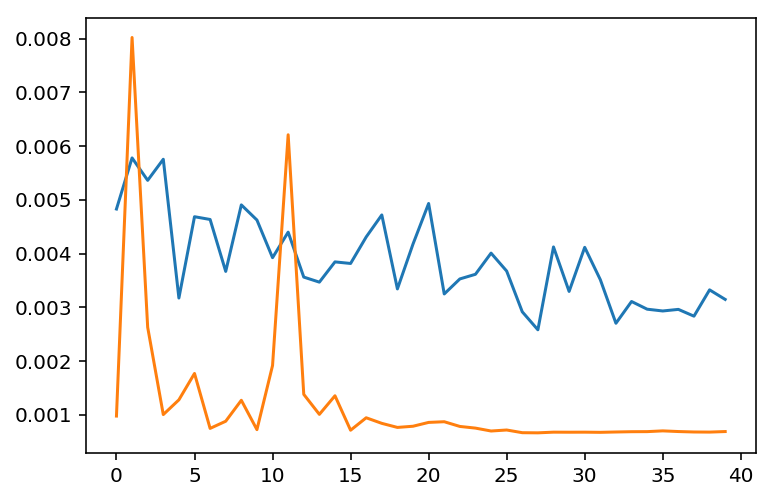

In [34]:
model.save('model.h5')
plt.plot(range(len(h.history['loss'][10:])), h.history['loss'][10:])
plt.plot(range(len(h.history['loss'][10:])), h.history['val_loss'][10:])

# 可视化

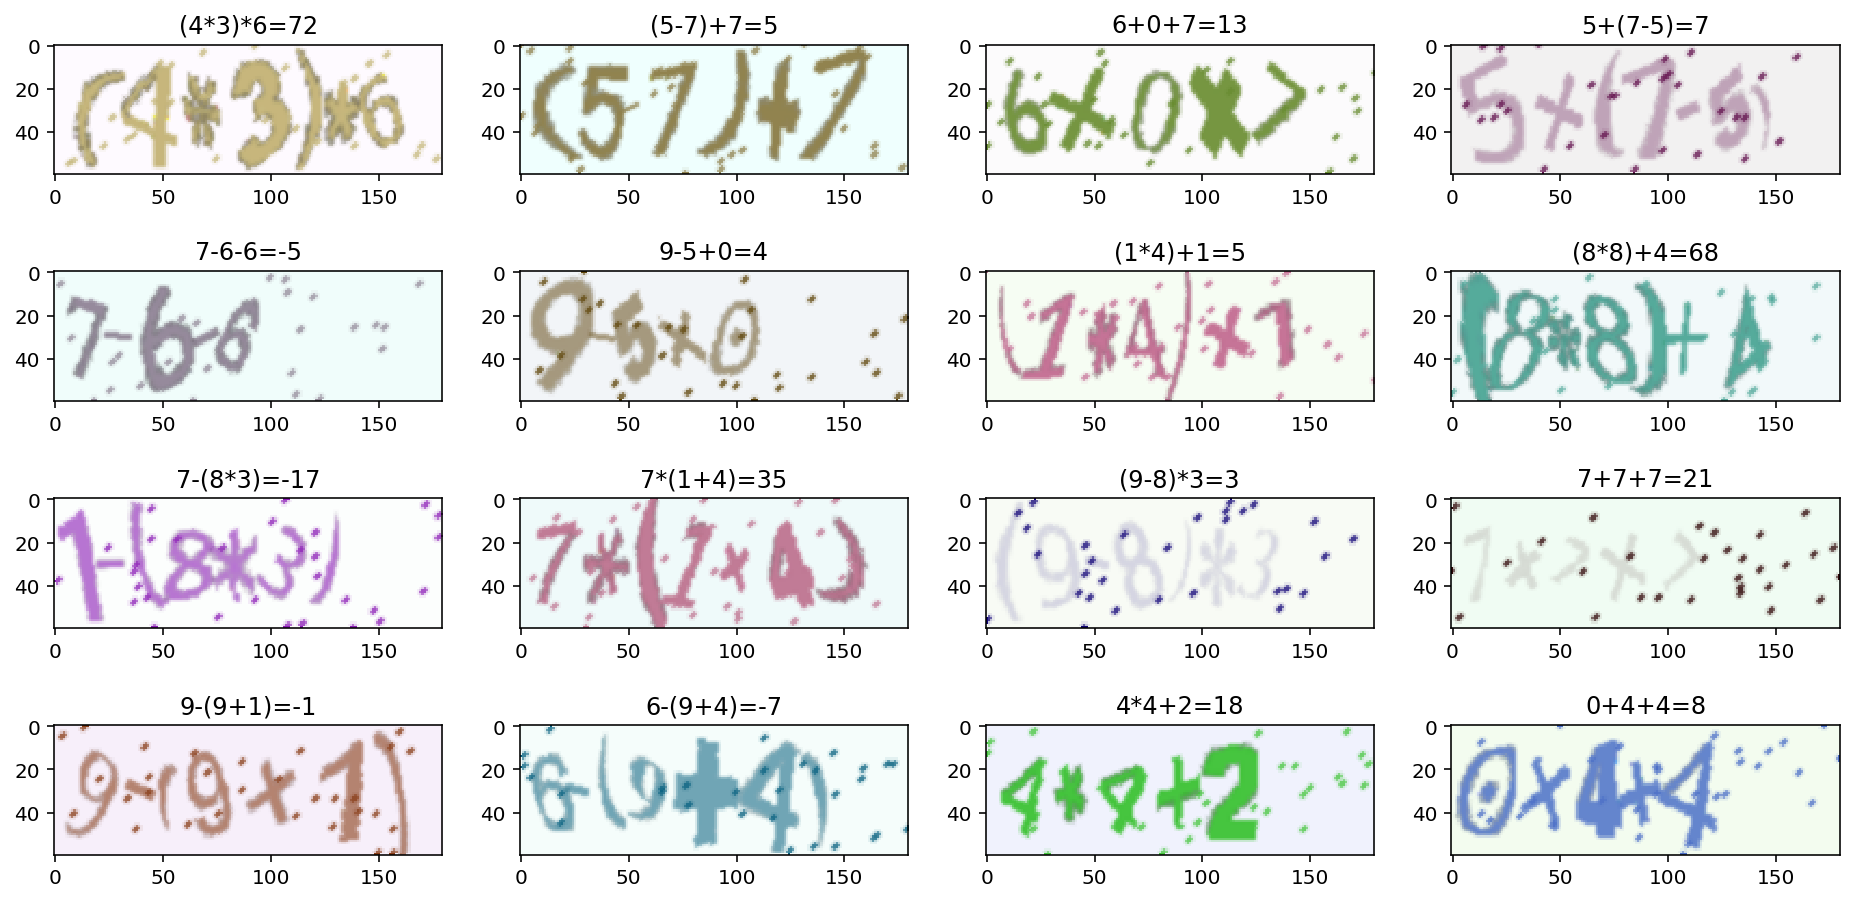

In [31]:
[X_test, y_test, _, _], _  = next(gen(16))
y_pred = base_model.predict(X_test)
shape = y_pred[:,2:,:].shape
out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:, :n_len]

plt.figure(figsize=(16, 8))
for i, (img, label) in enumerate(zip(X_test, out)):
    plt.subplot(4, 4, i+1)
    plt.imshow(img.transpose(1, 0, 2))
    s = ''.join([characters[x] for x in out[i] if x > -1])
    try:
        plt.title('%s=%d'%(s, eval(s)))
    except:
        plt.title(s)
        print s
        pass